In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
MAX_SPEED = 23.62

trips = pd.read_csv("data/trips.csv")
trips = trips[(trips.speed < MAX_SPEED) & (trips.previous_speed < MAX_SPEED)]
trips = trips.dropna().reset_index(drop=True)
len(trips.speed)

mspeeds = trips.groupby(["leg", "last_stop", "weekend", "hour"]).speed.mean()
mspeeds.name = "mean_speed"
trips = trips.join(mspeeds, on=["leg", "last_stop", "weekend", "hour"], how="left")

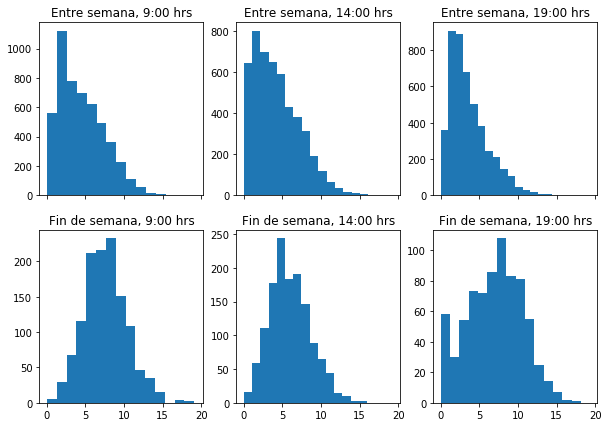

In [3]:
hours = [9, 14, 19]
weekend = [False, True]
f, axes = plt.subplots(len(weekend), len(hours), sharex=True, figsize=(10, 7))
f.canvas.set_window_title("Histograma de velocidades (m/s)")
for i, w in enumerate(weekend):
    for j, h in enumerate(hours):
        ax = axes[i][j]
        title = "Entre " if not w else "Fin de "
        title += "semana, {}:00 hrs".format(h)
        ax.set_title(title)
        ax.hist(trips[(trips.hour == h) & (trips.weekend == w)].speed, bins=15)

(array([4.050e+03, 6.470e+03, 7.743e+03, 7.533e+03, 7.227e+03, 7.727e+03,
        7.734e+03, 7.107e+03, 6.449e+03, 6.145e+03, 5.549e+03, 4.521e+03,
        3.569e+03, 2.498e+03, 1.850e+03, 1.202e+03, 7.660e+02, 4.430e+02,
        3.070e+02, 1.800e+02, 7.400e+01, 5.500e+01, 3.300e+01, 1.400e+01,
        1.200e+01, 5.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 4.000e+00]),
 array([5.81409646e-09, 7.79020332e-01, 1.55804066e+00, 2.33706098e+00,
        3.11608131e+00, 3.89510164e+00, 4.67412196e+00, 5.45314229e+00,
        6.23216262e+00, 7.01118294e+00, 7.79020327e+00, 8.56922359e+00,
        9.34824392e+00, 1.01272642e+01, 1.09062846e+01, 1.16853049e+01,
        1.24643252e+01, 1.32433456e+01, 1.40223659e+01, 1.48013862e+01,
        1.55804065e+01, 1.63594269e+01, 1.71384472e+01, 1.79174675e+01,
        1.86964878e+01, 1.94755082e+01, 2.02545285e+01, 2.10335488e+01,
        2.18125691e+01, 2.25915895e+01, 2.33706098e+01]),
 <a list of 30 Patch objects>)

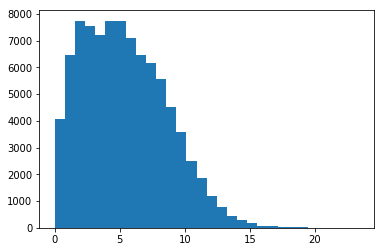

In [4]:
plt.hist(trips.speed, bins=30)

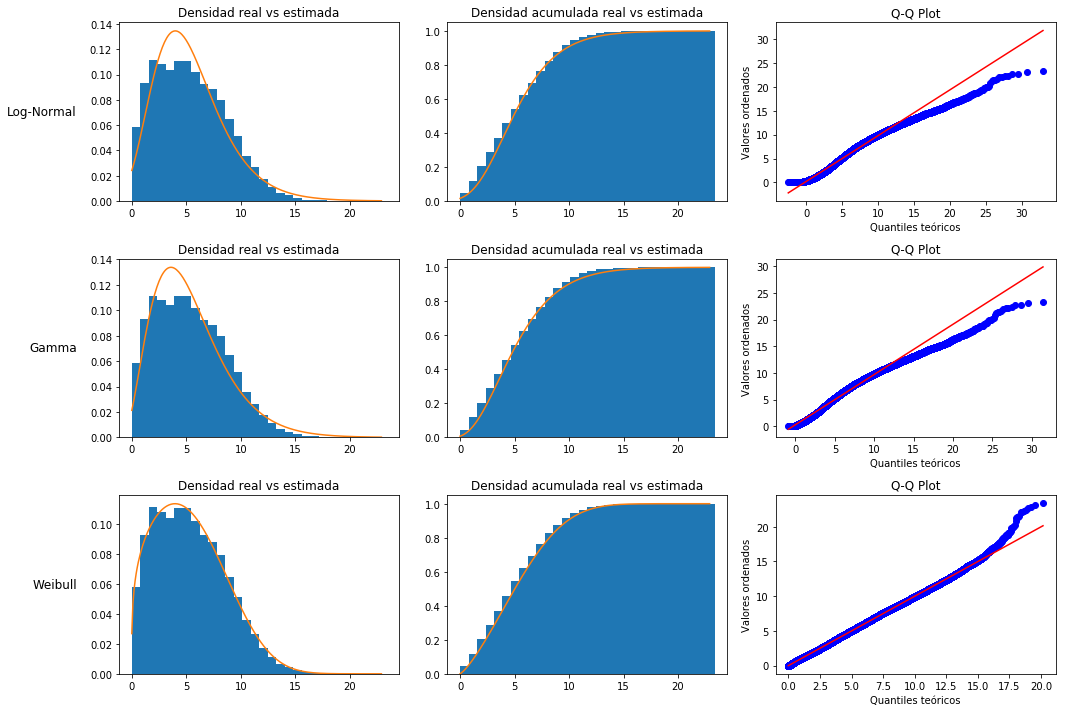

In [5]:
from scipy.stats import probplot
from scipy.stats import distributions as d
def fit_dist(axes, dist, name):
    axes[0].annotate(name, xy=(0, 0.5), xytext=(-axes[0].yaxis.labelpad - 5, 0), 
                     xycoords=axes[0].yaxis.label, textcoords="offset points",
                     size="large", ha="right", va="center")
    axes[0].hist(trips.speed, bins=30, density=True)
    axes[0].set_title("Densidad real vs estimada")
    params = dist.fit(trips.speed)
    g = dist(*params)
    x = np.arange(0, 23, 0.1)
    axes[0].plot(x, g.pdf(x))

    axes[1].set_title("Densidad acumulada real vs estimada")
    axes[1].hist(trips.speed, cumulative=True, density=True, bins=30)
    axes[1].plot(x, g.cdf(x))

    probplot(trips.speed, sparams=params, dist=dist, plot=axes[2])
    axes[2].set_title("Q-Q Plot")
    axes[2].set_xlabel("Quantiles teóricos")
    axes[2].set_ylabel("Valores ordenados")

    
f, aaxes = plt.subplots(3, 3, figsize=(15, 10))
dists = [d.lognorm, d.gamma, d.exponweib]
names = ["Log-Normal", "Gamma", "Weibull"]

for axes, dist, name in zip(aaxes, dists, names):
    fit_dist(axes, dist, name)
    
f.tight_layout()


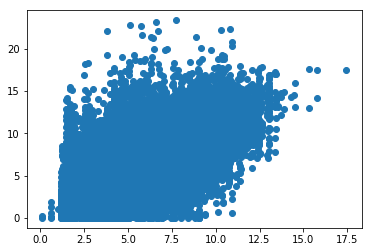

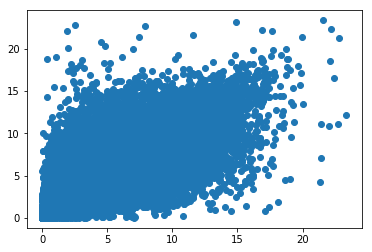

In [6]:
plt.scatter(trips.mean_speed, trips.speed)
plt.figure()
plt.scatter(trips.previous_speed, trips.speed)

In [7]:
X = trips[["mean_speed", "previous_speed"]].values/MAX_SPEED
y = trips.speed/MAX_SPEED


In [8]:
import pymc3 as pm
from theano import shared
features = shared(X)
# model
with pm.Model() as model:
    beta = pm.HalfCauchy("beta", beta=2.5, shape=X.shape[1])
    expected = pm.Deterministic("expected",pm.math.matrix_dot(features, beta))
    precision = pm.HalfCauchy("precision", beta=2.5)
    target_ = pm.Gamma("target", mu=expected, sd=1/precision, observed=y)
    approx = pm.fit(start=pm.find_MAP())

# inference
n_samples = 5000
trace = approx.sample(n_samples)
pm.traceplot(trace, varnames=["beta", "precision"])

In [ ]:
# prediction
post = pm.sample_ppc(trace, model=model)
pred = post["target"].mean(axis=0)
plt.figure()

In [ ]:
# Predichos vs reales
plt.scatter(pred*MAX_SPEED, trips.speed)
plt.xlab("Predichos")
plt.ylab("Reales")

# Residuales
plt.hist(pred*MAX_SPEED - trips.speed, bins=20)
plt.title("Residuales")

In [10]:
pm.trace_to_dataframe(trace, varnames=["beta", "precision"]).to_csv("data/posterior_samples.csv", index=False)